In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from sklearn.linear_model import LinearRegression
import os
import io

In [2]:
# set up graphing defaults to look pretty
sns.set_palette('pastel')
sns.set_theme(rc={'axes.facecolor':'lightgrey'})

# Data Analysis
It's time to do our final analysis. Here, we can use all we learned from our EDA to answer our question:
##### **In the English Premier League, does a managerial change postively affect a team's performance in the next ten games in terms of win/loss ratio, points per game, and shots per quantity of possession, among various other metrics?** 

To start, here's a summary of what we learned from EDA:
- The representation in our dataset is left-skewed, and many metrics are right-skewed. This is mostly due to the way our data is set up: The higher performing a team is, the longer they'll stay in the League, and therefore the more represented they will be in our dataset. 
    - There are a few teams (ex: Crystal Palace, Arsenal, Tottenham) that are performing really well, getting super high metrics, and staying in the league for a long time.
- Besides goals scored, the metrics that contributed the most to a positive result were Shots on Target, Pass Completion, Shots, and Corners. The metrics that negatively contributed to a positive result were Yellow Cards Earned and Fouls Committed.
    - From this, we can safely define the former metrics as positive, and the latter as negative.
    - In our analysis, we'll want to define an "increase in performance" as an increase in the positive metrics, and a decrease in the negative metrics. However, we can analyze both separately.

Our final analysis will roughly follow this procedure:
1. Combine the metrics and managers datasets, so we know the manager for each team for each match.
2. Graph the changes in metrics for each manager over time, looking specifically to see if there's a jump in the beginning.
3. Calculate the average metrics in the first 10 matches of a manager's term.
4. Run a hypothesis test to see if there is significant improvement in performance than the entirety of the manager's *predecessor's* term.
    - "Significant Improvement" will be defined as significantly higher positive metrics, and significantly lower negative metrics.
    - More details on this process below.
5. Repeat for every manager for every team.
    - Using this, find the proportion of teams who experienced a significant new-manager bounce.
6. Present results.

## Step 1: Combining the datasets
In order to proceed with our analysis, we'll have to put our manager data into our metrics data. To do this, we'll add a column into the metrics data, `'Manager'`, which simply gives the name of the manager for the team during the time of that match.

In [3]:
metrics = pd.read_csv(Path('data') / 'metrics_clean.csv')
metrics.tail()

,Date,TotalGoalsScored,FullTimeResult,Team,Shots,ShotsOnTarget,Pass Cmp %,FoulsCommited,Corners,YellowCardsEarned,RedCardsEarned,IsHome,Won
3499,08/12/18,0,A,Leicester,11,3,76.2,12,6,3,0,True,False
3500,08/12/18,4,H,Man United,20,11,83.4,11,10,1,0,True,True
3501,08/12/18,3,H,West Ham,13,6,78.1,10,5,1,0,True,True
3502,09/12/18,1,A,Newcastle,12,4,76.1,10,4,2,1,True,False
3503,10/12/18,2,D,Everton,12,5,75.3,13,6,1,0,True,NaN


In [4]:
managers = pd.read_csv(Path('data')/'managers_clean.csv')
managers

,Club,Predecessor,Join date,Coach
0,Chelsea,David Webb,30/6/1993,Glenn Hoddle
1,Tottenham,Doug Livermore,19/6/1993,Osvaldo Ardiles
2,Tottenham,Ray Clemence,19/6/1993,Osvaldo Ardiles
3,Crystal Palace,Steve Coppell,17/5/1993,Alan Smith
4,Nottingham Forest,Brian Clough,8/5/1993,Frank Clark
...,...,...,...,...
404,Wolves,Bruno Lage,2/10/2022,Steve Davis
405,Brighton,Andrew Crofts,17/9/2022,Roberto De Zerbi
406,Chelsea,Thomas Tuchel,7/9/2022,Graham Potter
407,Brighton,Graham Potter,7/9/2022,Andrew Crofts


Let's convert everything into Timestamps first, to make comparisons easier.

In [5]:
pd.to_datetime('10/01/17', format='%d/%m/%y')

Timestamp('2017-01-10 00:00:00')

In [6]:
metrics['Date'] = pd.to_datetime(metrics['Date'], format='%d/%m/%y')
managers['Join date'] = pd.to_datetime(managers['Join date'], format='%d/%m/%Y')
metrics['Date'].iloc[-1].month

12

To combine the two, we'll add a preliminary column with a list of tuples of the form `(join_date, manager, predecessor)` for each team.

In [7]:
# Helper function to get list of man/date tuples for a given df
def get_man_dates(df):
    all_mans = list(zip(df['Join date'], df['Coach'], df['Predecessor']))
    sorted_mans = sorted(all_mans, key=lambda x: x[0])
    result = []
    name_counts = dict()
    for date, name, pred in sorted_mans:
        if name in name_counts:
            name_counts[name] += 1
            name = f'{name}_{name_counts[name]}'
        else:
            name_counts[name] = 1
        if pred in name_counts and name_counts[pred] > 1:
            pred = f'{pred}_{name_counts[pred]}'
        result.append((date, name, pred))
    return result
all_managers = managers.groupby('Club')[['Join date', 'Coach', 'Predecessor']].apply(get_man_dates).reset_index()
all_managers.columns = ['Team', 'All Managers']
all_managers.head()

,Team,All Managers
0,Arsenal,"[(1995-02-21 00:00:00, Stewart Houston, George..."
1,Aston Villa,"[(1994-11-10 00:00:00, Brian Little, Ron Atkin..."
2,Birmingham,"[(2007-11-18 00:00:00, Eric Black, Steve Bruce..."
3,Blackburn,"[(1995-06-30 00:00:00, Ray Harford, Sir Kenny ..."
4,Bolton,"[(1996-01-07 00:00:00, Phil Brown, Roy McFarla..."


It should be noted for the special case where managers leave and are rehired, their names are numbered by their term number. For example, Keith Millen got rehired twice for Crystal Palace, so his terms are labeled "Keith Millen", "Keith Millen_2", and "Keith Millen_3". This is reflected in the predecessor column as well.

In [8]:
all_managers.iloc[13]['All Managers']

[(Timestamp('1993-05-17 00:00:00'), 'Alan Smith', 'Steve Coppell'),
 (Timestamp('1995-05-15 00:00:00'), 'Steve Coppell', 'Alan Smith'),
 (Timestamp('1998-03-13 00:00:00'), 'Attilio Lombardo', 'Steve Coppell'),
 (Timestamp('1998-04-29 00:00:00'), 'Ray Lewington', 'Attilio Lombardo'),
 (Timestamp('1998-05-10 00:00:00'), 'Terry Venables', 'Ray Lewington'),
 (Timestamp('2013-10-23 00:00:00'), 'Keith Millen', 'Ian Holloway'),
 (Timestamp('2013-11-23 00:00:00'), 'Tony Pulis', 'Keith Millen'),
 (Timestamp('2014-08-14 00:00:00'), 'Keith Millen_2', 'Tony Pulis'),
 (Timestamp('2014-08-27 00:00:00'), 'Neil Warnock', 'Keith Millen_2'),
 (Timestamp('2014-12-27 00:00:00'), 'Keith Millen_3', 'Neil Warnock'),
 (Timestamp('2015-01-02 00:00:00'), 'Alan Pardew', 'Keith Millen_3'),
 (Timestamp('2016-12-22 00:00:00'), 'Sam Allardyce', 'Alan Pardew'),
 (Timestamp('2017-05-23 00:00:00'), 'Frank de Boer', 'Sam Allardyce'),
 (Timestamp('2017-09-11 00:00:00'), 'Roy Hodgson', 'Frank de Boer'),
 (Timestamp('2021-

In [9]:
metrics_managers = metrics.merge(all_managers, on='Team', how='inner')
metrics_managers.head(3)

,Date,TotalGoalsScored,FullTimeResult,Team,Shots,ShotsOnTarget,Pass Cmp %,FoulsCommited,Corners,YellowCardsEarned,RedCardsEarned,IsHome,Won,All Managers
0,2017-01-01,0,H,Crystal Palace,7,4,NaN,7,4,1,0,False,False,"[(1993-05-17 00:00:00, Alan Smith, Steve Coppe..."
1,2017-01-14,0,H,Crystal Palace,10,1,NaN,14,2,2,0,False,False,"[(1993-05-17 00:00:00, Alan Smith, Steve Coppe..."
2,2017-01-31,2,A,Crystal Palace,11,4,NaN,23,3,4,0,False,True,"[(1993-05-17 00:00:00, Alan Smith, Steve Coppe..."


Now, we'll search within these dictionaries for every match for the manager with the latest join date that is still before the match's date. This will tell us which manager managed the team at the time of that match.

In [10]:
# Helper function: returns the manager name for a single match
row = metrics_managers.iloc[877]
def get_manager(row):
    match_date = row['Date']
    manager_tups = row['All Managers']
    if not manager_tups:
        return np.NaN
    for i in range(len(manager_tups)):
        date, _, _ = manager_tups[i]
        if date > match_date:
            return manager_tups[i-1][1:]
    return manager_tups[-1][1:]
get_manager(row)

('Jürgen Klopp', 'Brendan Rodgers')

In [11]:
row['All Managers']

[(Timestamp('1994-01-28 00:00:00'), 'Roy Evans', 'Graeme Souness'),
 (Timestamp('1998-11-11 00:00:00'), 'Gérard Houllier', 'Roy Evans'),
 (Timestamp('2004-06-30 00:00:00'), 'Rafael Benítez', 'Gérard Houllier'),
 (Timestamp('2010-06-30 00:00:00'), 'Roy Hodgson', 'Rafael Benítez'),
 (Timestamp('2011-01-07 00:00:00'), 'Sir Kenny Dalglish', 'Roy Hodgson'),
 (Timestamp('2012-05-16 00:00:00'), 'Brendan Rodgers', 'Sir Kenny Dalglish'),
 (Timestamp('2015-10-04 00:00:00'), 'Jürgen Klopp', 'Brendan Rodgers')]

In [12]:
metrics_managers['Manager_pred'] = metrics_managers.apply(get_manager, axis=1)
metrics_managers['Manager'] = metrics_managers['Manager_pred'].apply(lambda x: x[0])
metrics_managers['Predecessor'] = metrics_managers['Manager_pred'].apply(lambda x: x[1])
metrics_managers = metrics_managers.drop(['All Managers', 'Manager_pred'], axis=1)
metrics_managers.head()

,Date,TotalGoalsScored,FullTimeResult,Team,Shots,ShotsOnTarget,Pass Cmp %,FoulsCommited,Corners,YellowCardsEarned,RedCardsEarned,IsHome,Won,Manager,Predecessor
0,2017-01-01,0,H,Crystal Palace,7,4,NaN,7,4,1,0,False,False,Sam Allardyce,Alan Pardew
1,2017-01-14,0,H,Crystal Palace,10,1,NaN,14,2,2,0,False,False,Sam Allardyce,Alan Pardew
2,2017-01-31,2,A,Crystal Palace,11,4,NaN,23,3,4,0,False,True,Sam Allardyce,Alan Pardew
3,2017-02-11,0,H,Crystal Palace,6,1,NaN,14,5,3,0,False,False,Sam Allardyce,Alan Pardew
4,2017-03-04,2,A,Crystal Palace,10,4,NaN,12,5,1,0,False,True,Sam Allardyce,Alan Pardew


In [13]:
metrics_managers['Manager'].unique()

array(['Sam Allardyce', 'Roy Hodgson', 'Patrick Vieira', 'Frank de Boer',
       'Mauricio Pochettino', 'José Mourinho', 'Ryan Mason',
       'Nuno Espírito Santo', 'Antonio Conte', 'Claude Puel',
       'Ralph Hasenhüttl', 'Mauricio Pellegrino', 'Mark Hughes',
       'Brian Laws', 'Mike Jackson', 'Claudio Ranieri',
       'Craig Shakespeare_2', 'Brendan Rodgers_2', 'Michael Appleton',
       'Craig Shakespeare', 'Jürgen Klopp', 'Mike Phelan', 'Marco Silva',
       'Ole Gunnar Solskjær_2', 'Michael Carrick', 'Ralf Rangnick',
       'Arsène Wenger', 'Mikel Arteta', 'Unai Emery', 'Freddie Ljungberg',
       'Paul Clement', 'Leon Britton', 'Carlos Carvalhal',
       'Walter Mazzarri', 'Vladimir Ivic', 'Javi Gracia',
       'Quique Sánchez Flores', 'Hayden Mullins', 'Nigel Pearson',
       'Frank Lampard', 'Thomas Tuchel', 'Maurizio Sarri',
       'Andoni Iraola', 'Paul Lambert', 'Tony Pulis', 'Darren Moore',
       'Gary Megson', 'Alan Pardew', 'Colin Cooper', 'Steve Agnew',
       'Pep G

Finally, let's add the PointsWonByResult column back in, and drop `'Won'` and `'FullTimeResult'`, since the info in those two is also in PWBR.

In [14]:
result_points = metrics_managers['Won'].replace({
    True: 3.0,
    False: 0.0
}).fillna(1.0)
metrics_managers['PointsWonByResult'] = result_points
metrics_managers = metrics_managers.drop(['Won', 'FullTimeResult'], axis=1)
metrics_managers.head()

,Date,TotalGoalsScored,Team,Shots,ShotsOnTarget,Pass Cmp %,FoulsCommited,Corners,YellowCardsEarned,RedCardsEarned,IsHome,Manager,Predecessor,PointsWonByResult
0,2017-01-01,0,Crystal Palace,7,4,NaN,7,4,1,0,False,Sam Allardyce,Alan Pardew,0.0
1,2017-01-14,0,Crystal Palace,10,1,NaN,14,2,2,0,False,Sam Allardyce,Alan Pardew,0.0
2,2017-01-31,2,Crystal Palace,11,4,NaN,23,3,4,0,False,Sam Allardyce,Alan Pardew,3.0
3,2017-02-11,0,Crystal Palace,6,1,NaN,14,5,3,0,False,Sam Allardyce,Alan Pardew,0.0
4,2017-03-04,2,Crystal Palace,10,4,NaN,12,5,1,0,False,Sam Allardyce,Alan Pardew,3.0


Now we finally have one dataframe with all our metrics AND all our managers (including their predecessors)! We can finally get into the meat of our analysis, and work towards answering our question.

## Step 2: Graphing changes in metrics under each manager over time
This is a large task, and more for our own viewing purposes. If we did this for every manager for every team, this would take ages, and would produce a ton of graphs to look at. Let's first define a function to generate a graph like this, given a manager and a team.

In [15]:
# Defining our quantitative/qualitative columns to make it easier to do analysis later
quant_columns = ['TotalGoalsScored', 'Shots', 'ShotsOnTarget', 'Pass Cmp %', 'FoulsCommited', 'Corners', 'YellowCardsEarned', 'RedCardsEarned', 'PointsWonByResult']

Arsène Wenger


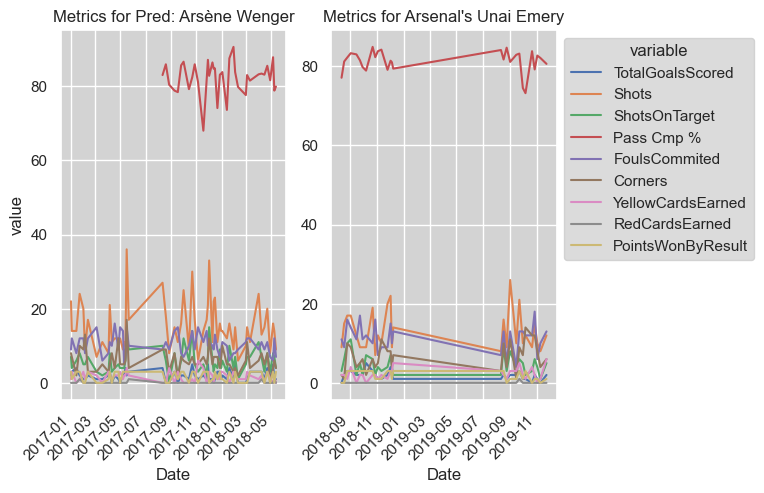

In [16]:
manager = 'Unai Emery'
team = 'Arsenal'
def graph_met_over_time(manager, team, specific_met=None):
    metrics_under_manager = (metrics_managers
                             [(metrics_managers['Manager'] == manager) 
                              & (metrics_managers['Team'] == team)])
    quant_mum = metrics_under_manager[quant_columns + ['Date']].copy()
    quant_mum['Position'] = [manager] * quant_mum.shape[0]
    predecessor = metrics_under_manager['Predecessor'].unique()[0]
    if predecessor == manager:
        predecessor += '_prev'
    metrics_under_pred = (metrics_managers
                          [(metrics_managers['Manager'] == predecessor) 
                           & (metrics_managers['Team'] == team)])
    quant_mup = metrics_under_pred[quant_columns + ['Date']].copy()
    quant_mup['Position'] = ['Pred: '+predecessor] * quant_mup.shape[0]
    mum_mup = pd.concat([quant_mum, quant_mup])
    print(predecessor)
    if specific_met:
        fig = sns.lineplot(data=mum_mup, x='Date', y=specific_met, hue='Position')
        fig.set(title=f'Metric for {team}\'s {manager}')
    else:
        plt.subplot(1, 2, 2,)
        fig = sns.lineplot(data=(quant_mum
                                 .drop('Position', axis=1)
                                 .melt('Date')), 
                           x='Date', y='value', hue='variable')
        plt.xticks(rotation=45, ha = 'right')
        plt.subplot(1, 2, 1)
        fig2 = sns.lineplot(data=(quant_mup
                                 .drop('Position', axis=1)
                                 .melt('Date')), 
                            x='Date', y='value', hue='variable')
        plt.xticks(rotation=45, ha = 'right')
        plt.legend([],[], frameon=False)
        fig.set(title=f'Metrics for {team}\'s {manager}', ylabel='')
        fig2.set(title=f'Metrics for Pred: {predecessor}')
    sns.move_legend(fig, 'upper left', bbox_to_anchor=(1,1))
    plt.xticks(rotation=45, ha = 'right')
    return fig
graph_met_over_time(manager, team);

For this manager, there were sporadic jumps throughout in all metrics. Let's look at a couple different teams and managers, and see what we can find.

Bournemouth Andoni Iraola
Gary O'Neil_2


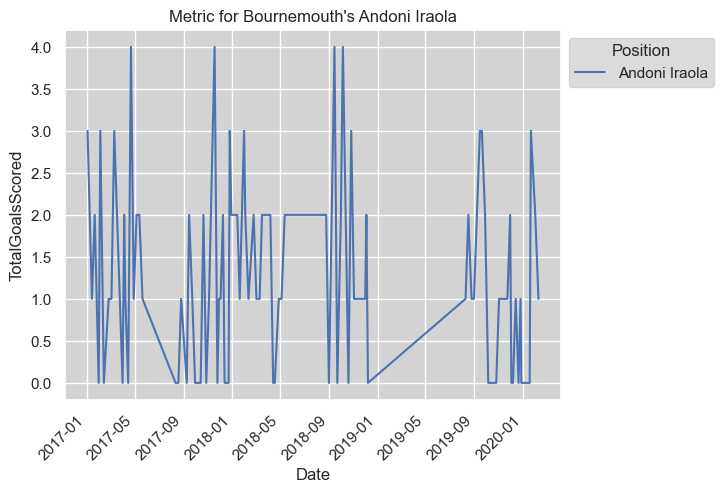

In [17]:
team = np.random.choice(metrics_managers['Team'].unique())
manager = np.random.choice(metrics_managers[metrics_managers['Team'] == team]['Manager'].unique())
print(team, manager)
graph_met_over_time(manager, team, specific_met='TotalGoalsScored'); # Graphing only one metric
plt.show()
    

### Step 3: Calculating average metrics for the first 10 games
Moving onto the next step, let's pick a manager and team and calculate the metrics for their first 10 games. We want to make sure the manager we pick has a predecessor with data in our dataset- otherwise, there's nothing to compare them to.

Southampton Mark Hughes
Mauricio Pellegrino


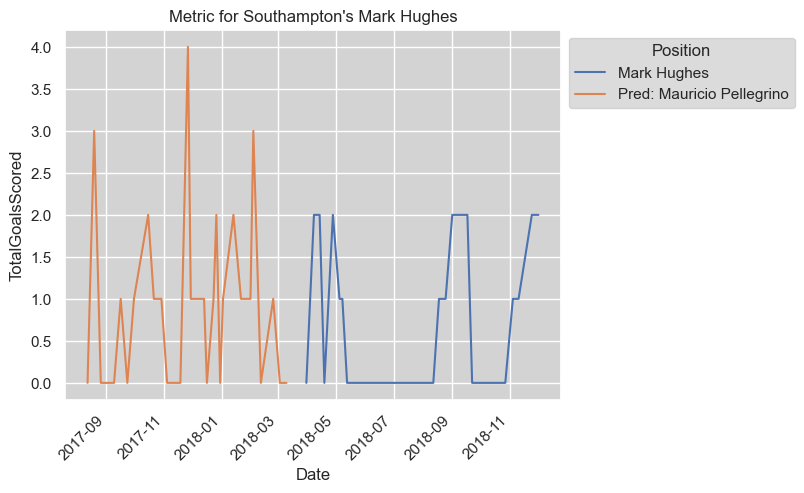

In [18]:
team = 'Southampton'
manager = 'Mark Hughes'
print(team, manager)
graph_met_over_time(manager, team, specific_met='TotalGoalsScored');
plt.show()

For the next two steps, we'll work with Southampton's Mark Hughes, comparing him with his predecessor, Mauricio Pellegrino.

First off, we want to calculate Mark's metrics for his first 10 games. The process we'll follow along with the reasons is outlined below:
1. Standardize all quantitative metrics based on Southampton's mean and std
    - This is so our metrics don't have higher influence depending on the units. For example, Pass Cmp % right now has higher raw values than any other column, since it stores percents that range from 0 to 100.
    - Doing this process by team also ensures that we're comparing scores within the scope of the team, not in the overall League.
    - We'll apply the following formula to each value in every quantitative column:
    $$\text{new value}=\frac{\text{old value} - \text{column mean}}{\text{column std}}$$
2. Take the mean of the means of all positive columns to get the Positive Metric Aggregate (PMA), and do the same to the negative columns to get the Negative Metric Aggregate (NMA)
    - This aggregation of the positive and negative columns ensures both positive and negative metrics are taken into account. Since there are more positive than negative metrics, it also avoids weighing the positive metrics higher.
    - "positive" and "negative" were determined in the EDA process, and are defined as follows:

<center>

| Effect | Metrics |
| --- | --- |
| Positive |Total Goals, Shots, Shots on Target, Pass Completion, and Corners |
| Negative |Yellow Cards Earned and Fouls Committed |
</center>

Later on, we'll compare the PMA, NMA, and average PWBR of each manager with those of their predecessor to see if PMA and PWBR are significantly higher, and NMA is significantly lower.

With all that in mind, let's get started!


In [19]:
hughes_sh_df = metrics_managers[(metrics_managers['Manager'] == 'Mark Hughes') & (metrics_managers['Team'] == 'Southampton')]
print(hughes_sh_df.shape)
hughes_sh_df.head()

(22, 14)


,Date,TotalGoalsScored,Team,Shots,ShotsOnTarget,Pass Cmp %,FoulsCommited,Corners,YellowCardsEarned,RedCardsEarned,IsHome,Manager,Predecessor,PointsWonByResult
427,2018-03-31,0,Southampton,9,0,71.6,16,9,3,0,False,Mark Hughes,Mauricio Pellegrino,0.0
428,2018-04-08,2,Southampton,15,8,69.1,7,6,1,1,False,Mark Hughes,Mauricio Pellegrino,0.0
429,2018-04-19,0,Southampton,6,2,71.2,10,3,0,0,False,Mark Hughes,Mauricio Pellegrino,1.0
430,2018-05-05,1,Southampton,11,5,71.9,12,4,4,1,False,Mark Hughes,Mauricio Pellegrino,1.0
431,2018-05-08,1,Southampton,13,8,68.9,15,6,1,0,False,Mark Hughes,Mauricio Pellegrino,3.0


In [20]:
hughes_first10 = hughes_sh_df.sort_values('Date', ascending=True).iloc[:10]
hughes_first10.shape

(10, 14)

Now that we have the metrics for Hughes' first 10 matches, we can go through the process to calculate the PMA, NMA, and average PWBR. 

First, let's standardize the metrics, based on all of Southampton's metrics.

In [21]:
from sklearn.preprocessing import StandardScaler
sh_scaler = StandardScaler()
sh_quant_mets = metrics_managers[metrics_managers['Team'] == 'Southampton'][quant_columns]
sh_scaler.fit(sh_quant_mets)
hughes_f10_std_mets = pd.DataFrame(sh_scaler.transform(hughes_first10[quant_columns]), columns=quant_columns)
hughes_f10_std_mets.head()

,TotalGoalsScored,Shots,ShotsOnTarget,Pass Cmp %,FoulsCommited,Corners,YellowCardsEarned,RedCardsEarned,PointsWonByResult
0,-1.084256,-0.696580,-1.971202,-0.304109,1.356033,1.262226,1.135562,-0.223607,-0.852163
1,0.871876,0.494640,1.659960,-0.693224,-1.141922,0.181200,-0.467046,3.689512,-0.852163
2,0.871876,-0.498043,1.206064,-0.335238,0.523381,-0.539483,2.738169,-0.223607,-0.852163
3,-1.084256,-1.292189,-1.063412,-0.366367,-0.309271,-0.899825,-1.268349,-0.223607,-0.028249
4,0.871876,0.296103,0.752169,-0.677660,0.245831,-0.179141,2.738169,-0.223607,1.619581


Then, we'll use these standardized metrics to calculate our positive/negative scores. We'll also calculate the avg PWBR here.

In [22]:
positive_metrics = ['TotalGoalsScored', 'Shots', 'ShotsOnTarget', 'Pass Cmp %', 'Corners']
negative_metrics = ['FoulsCommited', 'YellowCardsEarned']
hughes_f10_pma = hughes_f10_std_mets[positive_metrics].mean().mean()
hughes_f10_nma = hughes_f10_std_mets[negative_metrics].mean().mean()
hughes_f10_pwbr = hughes_f10_std_mets['PointsWonByResult'].mean()
hughes_f10_pma, hughes_f10_pwbr, hughes_f10_nma

(-0.2026613365710534, -0.11064000702262042, 0.6121331267111735)

These scores alone tell us that Hughes seems to have underperformed as a manager by Southampton standards, since his PMA and PWBR are lower than the average, and his NMA is higher. However, it *doesn't* tell us anything about his bounce: we have to compare his scores to that of his predecessor to get that.

## Step 4: Comparing to the Predecessor
First we have to find the metrics for his predecessor, Mauricio Pellegrino.

In [23]:
pelle_sh_df = metrics_managers[(metrics_managers['Manager'] == 'Mauricio Pellegrino') & (metrics_managers['Team'] == 'Southampton')]
print(pelle_sh_df.shape)
pelle_sh_df.head()

(30, 14)


,Date,TotalGoalsScored,Team,Shots,ShotsOnTarget,Pass Cmp %,FoulsCommited,Corners,YellowCardsEarned,RedCardsEarned,IsHome,Manager,Predecessor,PointsWonByResult
413,2017-08-26,0,Southampton,6,3,75.5,10,4,1,0,False,Mauricio Pellegrino,Claude Puel,1.0
414,2017-09-16,1,Southampton,13,4,78.5,13,5,1,0,False,Mauricio Pellegrino,Claude Puel,3.0
415,2017-09-30,1,Southampton,21,3,83.6,10,6,2,0,False,Mauricio Pellegrino,Claude Puel,0.0
416,2017-10-29,1,Southampton,6,1,77.4,10,7,1,0,False,Mauricio Pellegrino,Claude Puel,1.0
417,2017-11-18,0,Southampton,5,0,71.0,9,2,1,0,False,Mauricio Pellegrino,Claude Puel,0.0


Now, we'll follow the same process: Standardize, then calculate scores. The good news is, we already have a scaler fit for Southampton.

In [24]:
pelle_std_mets = pd.DataFrame(sh_scaler.transform(pelle_sh_df[quant_columns]), columns=quant_columns)
pelle_std_mets.head()

,TotalGoalsScored,Shots,ShotsOnTarget,Pass Cmp %,FoulsCommited,Corners,YellowCardsEarned,RedCardsEarned,PointsWonByResult
0,-1.084256,-1.292189,-0.609516,0.302912,-0.309271,-0.539483,-0.467046,-0.223607,-0.028249
1,-0.106190,0.097567,-0.155621,0.769850,0.523381,-0.179141,-0.467046,-0.223607,1.619581
2,-0.106190,1.685859,-0.609516,1.563646,-0.309271,0.181200,0.334258,-0.223607,-0.852163
3,-0.106190,-1.292189,-1.517307,0.598639,-0.309271,0.541542,-0.467046,-0.223607,-0.028249
4,-1.084256,-1.490726,-1.971202,-0.397497,-0.586821,-1.260167,-0.467046,-0.223607,-0.852163


In [25]:
pelle_pms = pelle_std_mets[positive_metrics].mean().mean()
pelle_nms = pelle_std_mets[negative_metrics].mean().mean()
pelle_pwbr = pelle_std_mets['PointsWonByResult'].mean()
pelle_pms, pelle_pwbr, pelle_nms

(0.0026866722542562282, -0.0831761754921827, -0.13485803607109872)

It seems Pellegrino actually performed a bit *better* than Hughes. But how significant is this difference? Was there a bounce?

### Hypothesis Testing
Here, we'll outline the procedure for our hypothesis test. We will be testing to see if the PMA and PWBR for a new manager (in this case, Hughes) in their first 10 matches are significantly higher than those of their predecessor (in this case, Pellegrino), and if the NMA is significantly *lower*.

PMA first:
rough procedure:
- assume that the pma does not depend on whether it was hughes or pelle
- create df with all of pelle's matches and hugh's first 10
- calculate diff in pma between hughes first 10 and pelle all
- permute 'manager' column, recalculate diff in pma (repeat many times)
- see if the proportion of simulated diff pma's that are higher than hughes pma (which is our p-value) is less than 0.05
***
$H_0$: The PMA of Hughes in his first 10 matches is equal to the PMA of Pellegrino.<br>
     $\quad\text{PMA}_{Hughes}-\text{PMA}_{Pellegrino} = 0$<br>
$H_a$: The PMA of Hughes is higher than the PMA of Pellegrino.<br>
     $\quad\text{PMA}_{Hughes}-\text{PMA}_{Pellegrino} > 0$<br>

Significance level: $\alpha = 0.05$
***

In [76]:
pelle = pelle_std_mets.assign(Manager = ['AAA'] * pelle_std_mets.shape[0])
hughes = hughes_f10_std_mets.assign(Manager = ['BBB'] * hughes_f10_std_mets.shape[0])
pop = pd.concat([pelle, hughes]).reset_index(drop=True)
# pma calculation function
def pma(df):
    return df[positive_metrics].mean().mean()

# observed test stat
obs_diff_pmas = pop.groupby('Manager').apply(pma).diff().iloc[-1]

# simulate test stats
N = 1000
sim_diffs = []
for _ in range(N):
    pop['perm_man'] = np.random.permutation(pop['Manager'])
    sim_diff_pmas = pop.groupby('perm_man').apply(pma).diff().iloc[-1]
    sim_diffs.append(sim_diff_pmas)

# sns.histplot(sim_diffs)
# calc p-val
pma_p_val = (np.array(sim_diffs) >= obs_diff_pmas).mean()
f"The P-value was {pma_p_val}"

'The P-value was 0.808'

As can be seen, the p-value was very high, meaning we fail to rejetc the null. Hughes' PMA in his first 10 matches was *not* significantly higher (nor actually higher at all) than his predecessor. 

What about the other stats, NMA and PWBR? We'll run very similar hypothesis tests for those.
***
$H_0$: The average PWBR of Hughes in his first 10 matches is equal to the average PWBR of Pellegrino.<br>
     $\quad\text{PWBR}_{Hughes}-\text{PMA}_{Pellegrino} = 0$<br>
$H_a$: The average PWBR of Hughes is higher than the PWBR of Pellegrino.<br>
     $\quad\text{PWBR}_{Hughes}-\text{PWBR}_{Pellegrino} > 0$<br>

Significance level: $\alpha = 0.05$
***

In [77]:
# observed test stat
obs_diff_pwbr = pop.groupby('Manager')['PointsWonByResult'].mean().diff().iloc[-1] * -1
print(obs_diff_pwbr)
# simulate test stats
N = 1000
sim_diffs = []
for _ in range(N):
    pop['perm_man'] = np.random.permutation(pop['Manager'])
    sim_diff_pwbr = pop.groupby('perm_man')['PointsWonByResult'].mean().diff().iloc[-1] * -1
    sim_diffs.append(sim_diff_pwbr)

# sns.histplot(sim_diffs)
# calc p-val
pwbr_p_val = (np.array(sim_diffs) >= obs_diff_pwbr).mean()
f"The P-value was {pwbr_p_val}"

0.027463831530437702


'The P-value was 0.556'

***
$H_0$: The NMA of Hughes in his first 10 matches is equal to the NMA of Pellegrino.<br>
     $\quad\text{NMA}_{Hughes}-\text{NMA}_{Pellegrino} = 0$<br>
$H_a$: The NMA of Hughes is lower than the NMA of Pellegrino.<br>
     $\quad\text{NMA}_{Hughes}-\text{NMA}_{Pellegrino} < 0$<br>

Significance level: $\alpha = 0.05$
***

0.7469911627822722


'The P-value was 0.985'

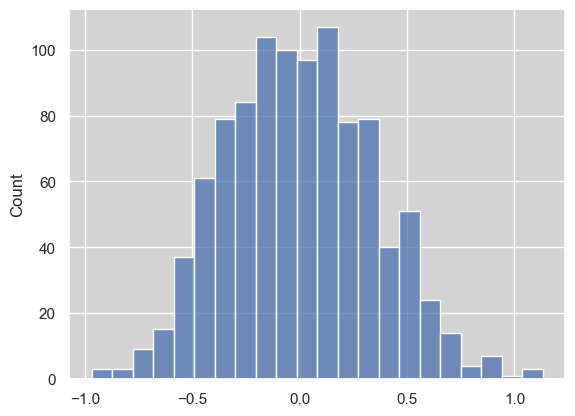

In [83]:
# observed test stat
def nma(df):
    return df[negative_metrics].mean().mean()
obs_diff_nma = pop.groupby('Manager').apply(nma).diff().iloc[-1]
print(obs_diff_nma)

# simulate test stats
N = 1000
sim_diffs = []
for _ in range(N):
    pop['perm_man'] = np.random.permutation(pop['Manager'])
    sim_diff_nma = pop.groupby('perm_man').apply(nma).diff().iloc[-1]
    sim_diffs.append(sim_diff_nma)

sns.histplot(sim_diffs)
# calc p-val
nma_p_val = (np.array(sim_diffs) <= obs_diff_nma).mean()
f"The P-value was {nma_p_val}"

In [79]:
pma_p_val, pwbr_p_val, nma_p_val

(0.808, 0.556, 0.017)

Let's reflect. ALL of our p-values were (much) higher than our chosen significance level of 0.05. From this, we can determine that Hughes showed no significant improvement over Pellegrino in his first ten matches. However, this makes sense: When we looked at the PMA, NMA, and PWBR separately, they were all worse for Hughes' first 10 than for Pellegrino. So we know Hughes did *not* have a bounce. What about the other managers, for the other teams?

### Step 5: Repeat hypothesis tests for all managers, across all teams
This is the biggest step of our analysis. How many of the managers we have data on experienced a significant bounce in their metrics? To determine this, we'll have to repeat the above processes for every manager, within every team.

To make this process easier, we'll define a function that runs a permutation test given a dataframe of metrics for a single team `'df'`, a manager/predecessor name pair `'man_pred'`, and stat to calculate `'stat'`, that's either `PMA`, `NMA`, or `PWBR`. It'll go through steps 3 and 4 of our analysis for the given manager and give us the resulting p-value.

In [95]:
def manager_perm_test(df, man_pred, stat, N = 1000, showplot=False):
    """Runs a permutation test, determining if the manager/predecessor pair given had a bounce

    Args:
        df (DataFrame): df of metrics for just one team
        man_pred (tuple): (manager name, predecessor name)
        stat (str): name of statistic ('PMA', 'NMA', or 'PWBR')
        N (int, optional): Number of iterations to run. Defaults to 1000.
        showplot (bool, optional): Whether or not to display the histogram of 
            simulated test statistics. Defaults to False.
    """
    def fit_stdscaler(df):
        team_scaler = StandardScaler()
        team_quant_mets = df[quant_columns]
        team_scaler.fit(team_quant_mets)
        return sh_scaler

    def get_std_df(df, scaler, manager, first10=False):
        man_team = (df
            [(df['Manager'] == manager)]
            .sort_values('Date'))
        if man_team.empty:
            return pd.DataFrame()
        if first10:
            man_team = man_team.iloc[:10]
        man_team_std = pd.DataFrame(
            scaler.transform(man_team[quant_columns]),
            columns=quant_columns)
        return man_team_std

    def get_stat_func(stat):
        positive_metrics = ['TotalGoalsScored', 'Shots', 'ShotsOnTarget', 'Pass Cmp %', 'Corners']
        negative_metrics = ['FoulsCommited', 'YellowCardsEarned'] # remind ourselves what we're considering positive and negative
        if stat == 'PMA':
            return lambda df: df[positive_metrics].mean().mean()
        if stat == 'NMA':
            return lambda df: df[negative_metrics].mean().mean()
        if stat == 'PWBR':
            return lambda df: df['PointsWonByResult'].mean()
        raise ValueError('Invalid stat')

    manager, pred_name = man_pred
    scaler = fit_stdscaler(df)
    man_f10_std = get_std_df(df, scaler, manager, first10=True)
    pred_std = get_std_df(df, scaler, pred_name)
    if pred_std.empty:
        return 1

    pred = pred_std.assign(Manager = ['AAA'] * pred_std.shape[0])
    man = man_f10_std.assign(Manager = ['BBB'] * man_f10_std.shape[0])
    pop = pd.concat([pred, man]).reset_index(drop=True)
    func = get_stat_func(stat)

    # observed test stat
    obs_stats = pop.groupby('Manager').apply(func)
    obs_ts = obs_stats.diff().iloc[-1]
    if showplot:
        print(obs_ts)
    # simulate test stats
    sim_ts_list = []
    for _ in range(N):
        pop['perm_man'] = np.random.permutation(pop['Manager'])
        stats = pop.groupby('perm_man').apply(func)
        sim_ts = stats.diff().iloc[-1]
        sim_ts_list.append(sim_ts)

    if showplot:
        sns.histplot(sim_ts_list)
        print(sim_ts_list)
    # calc p-val
    if stat == 'NMA':
        p_val = (np.array(sim_ts_list) <= obs_ts).mean()
    else:
        p_val = (np.array(sim_ts_list) >= obs_ts).mean()
    return p_val
sh_df = metrics_managers[metrics_managers['Team'] == 'Southampton']
manager_perm_test(sh_df, ('Mark Hughes', 'Mauricio Pellegrino'), 'NMA') # Should be around 0.99

0.984

Now, we'll loop through all manager-team pairs and calculate the p-values for all of them. Let's narrow it down to one team, Southampton, for now.

In [96]:
sh_man_pred = list(zip(sh_df['Manager'].unique(), sh_df['Predecessor'].unique()))
sh_man_pred

[('Claude Puel', 'Ronald Koeman'),
 ('Ralph Hasenhüttl', 'Kelvin Davis'),
 ('Mauricio Pellegrino', 'Claude Puel'),
 ('Mark Hughes', 'Mauricio Pellegrino')]

In [97]:
p_vals = [manager_perm_test(sh_df, man_pred, 'PMA') for man_pred in sh_man_pred]
p_vals

[1, 1, 0.419, 0.822]

None of the managers in Southampton had a bounce, by the looks of it

In [100]:
def get_pvals(team_df, stat):
    team_man_pred = list(zip(team_df['Manager'].unique(), team_df['Predecessor'].unique()))
    p_vals = [manager_perm_test(team_df, man_pred, stat) for man_pred in team_man_pred]
    return p_vals
get_pvals(tot_df, 'NMA')

[1, 0.798, 0.192, 0.494, 0.884]

Nor did any managers in tot

In [114]:
nma_pvals = metrics_managers.groupby('Team').apply(lambda df: get_pvals(df, 'NMA'));

/Users/tzhang04/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/tzhang04/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/Users/tzhang04/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/Users/tzhang04/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/tzhang04/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum

In [115]:
nma_pvals['Arsenal']

[1, 0.976, 0.897, 0.043]

In [117]:
nma_pvals_ser = all_pvals.explode()
nma_pvals_ser[nma_pvals_ser<0.1]

Team
Arsenal      0.053
Chelsea      0.039
Everton      0.093
Everton      0.091
Newcastle    0.087
Watford      0.098
dtype: object

In [118]:
team_df = metrics_managers[metrics_managers['Team']=='Arsenal']
team_man_pred = list(zip(team_df['Manager'].unique(), team_df['Predecessor'].unique()))
team_man_pred

[('Arsène Wenger', 'Pat Rice'),
 ('Mikel Arteta', 'Freddie Ljungberg'),
 ('Unai Emery', 'Arsène Wenger'),
 ('Freddie Ljungberg', 'Unai Emery')]

Frank Lampard


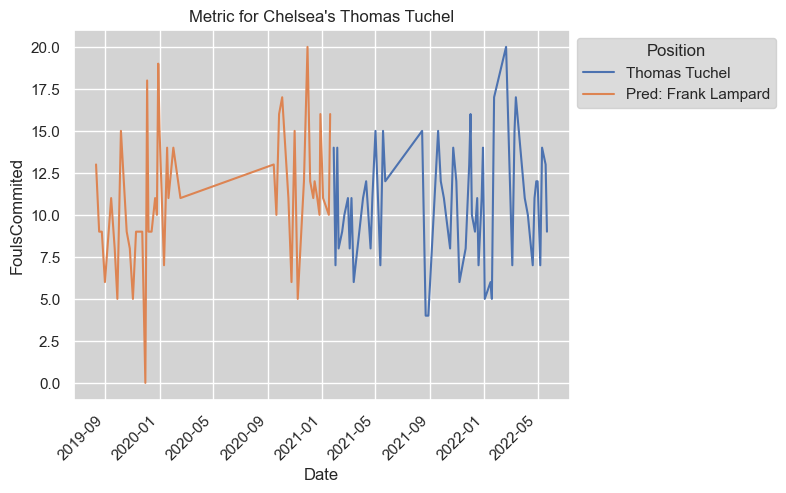

In [112]:
graph_met_over_time('Thomas Tuchel', 'Chelsea', specific_met='FoulsCommited');

In [119]:
pma_pvals = metrics_managers.groupby('Team').apply(lambda df: get_pvals(df, 'PMA'));

/Users/tzhang04/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/tzhang04/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/Users/tzhang04/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/Users/tzhang04/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/tzhang04/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum

In [120]:
pma_pvals_ser = all_pvals.explode()
pma_pvals_ser[pma_pvals_ser<0.1]

Team
Arsenal      0.053
Chelsea      0.039
Everton      0.093
Everton      0.091
Newcastle    0.087
Watford      0.098
dtype: object

In [121]:
pwbr_pvals = metrics_managers.groupby('Team').apply(lambda df: get_pvals(df, 'PWBR'));

/Users/tzhang04/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/tzhang04/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/Users/tzhang04/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/Users/tzhang04/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/tzhang04/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum

In [122]:
pwbr_pvals_ser = all_pvals.explode()
pwbr_pvals_ser[pma_pvals_ser<0.1]

Team
Arsenal      0.053
Chelsea      0.039
Everton      0.093
Everton      0.091
Newcastle    0.087
Watford      0.098
dtype: object